#### Segmento Cartão de Crédito
#### A área de crédito deseja avaliar a propensão ao risco de seus clientes e implementar políticas de redução da inadimplência


#### O que precisamos conhecer/prever/estimar sobre nossos clientes?


# Qual a Técnica que devo utilizar?

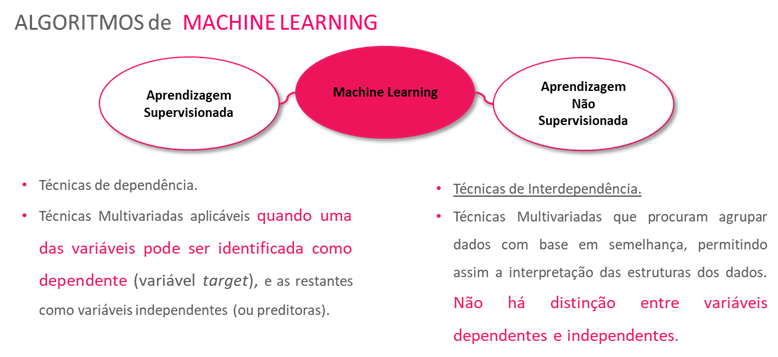

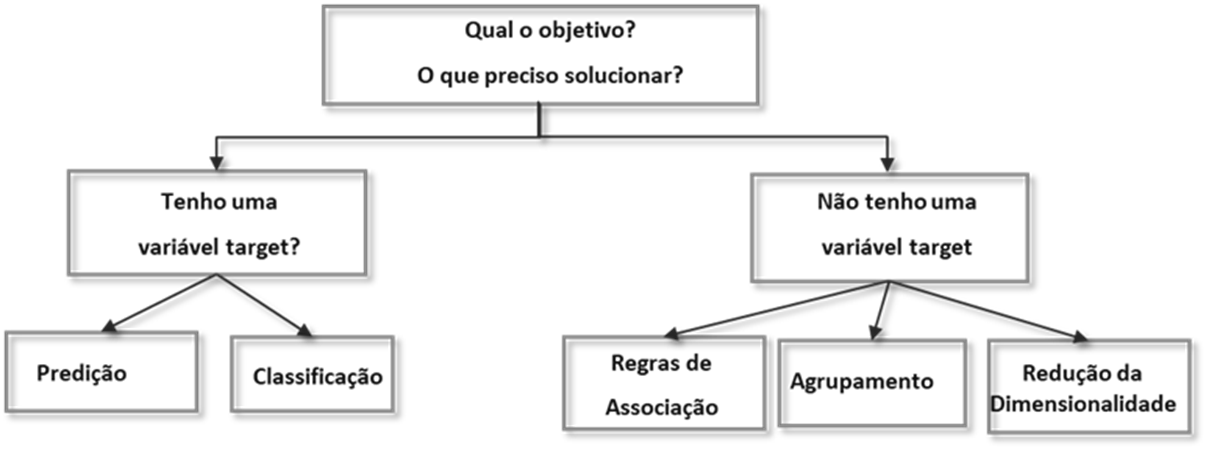!


## Técnicas Supervisionadas de Classificação: Modelo de Inadimplência PF

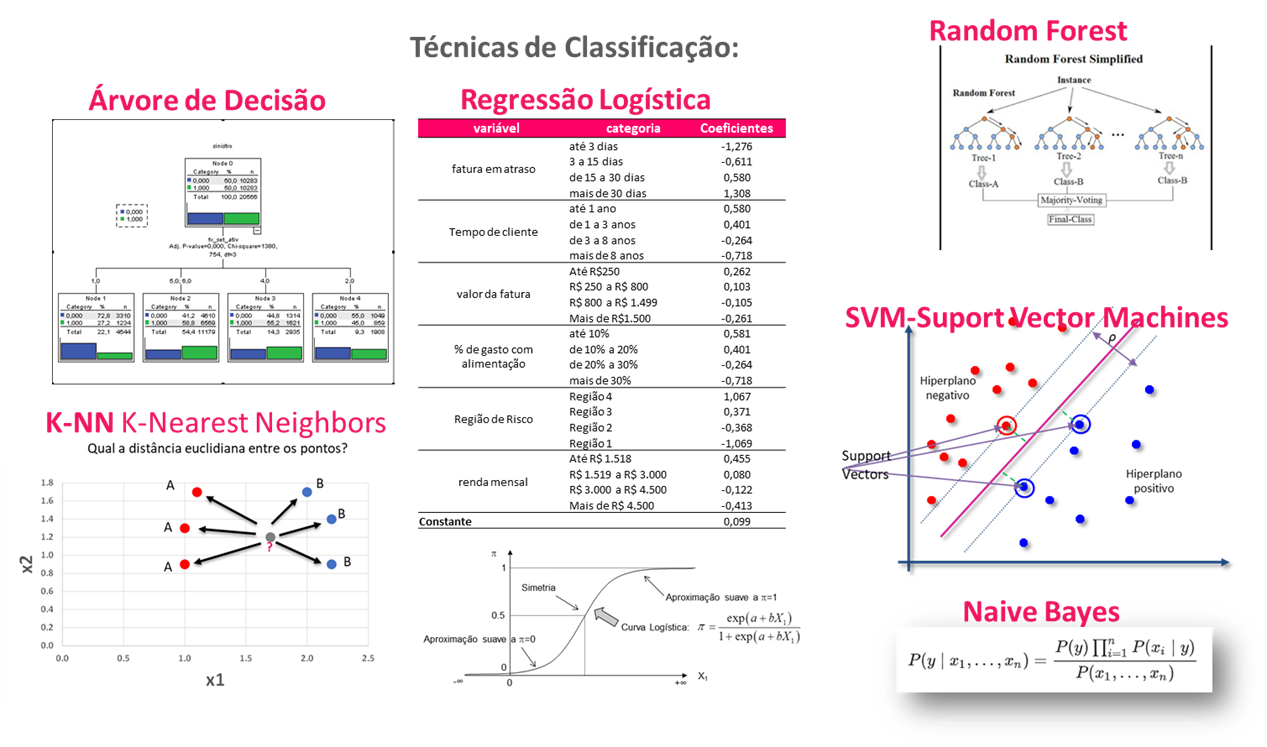

 # Quais as etapas que vamos seguir?

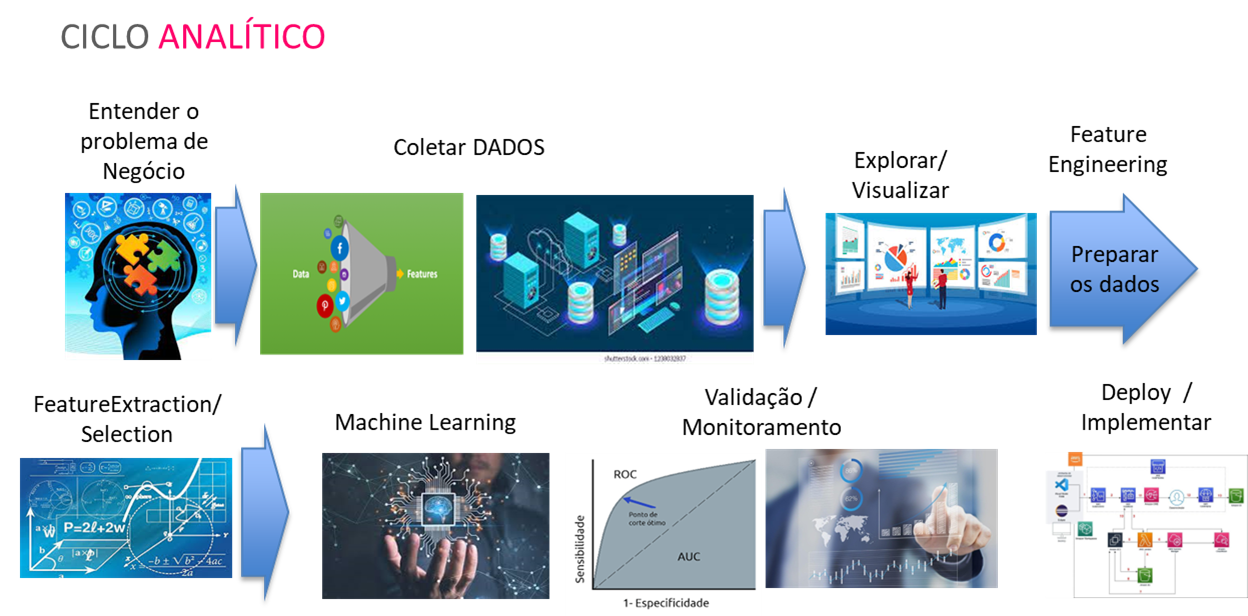

## Nossa Base de Dados e Dicionário de variáveis¶


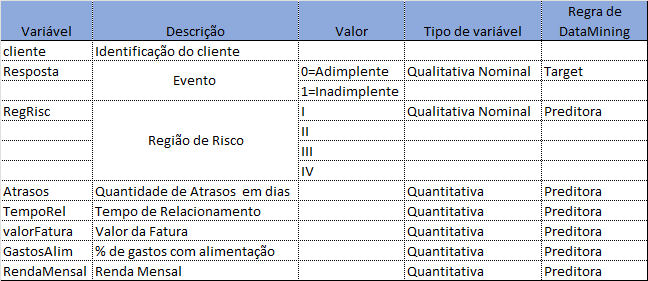

    Uma primeira etapa é a extração da base como buscar os dados!!!

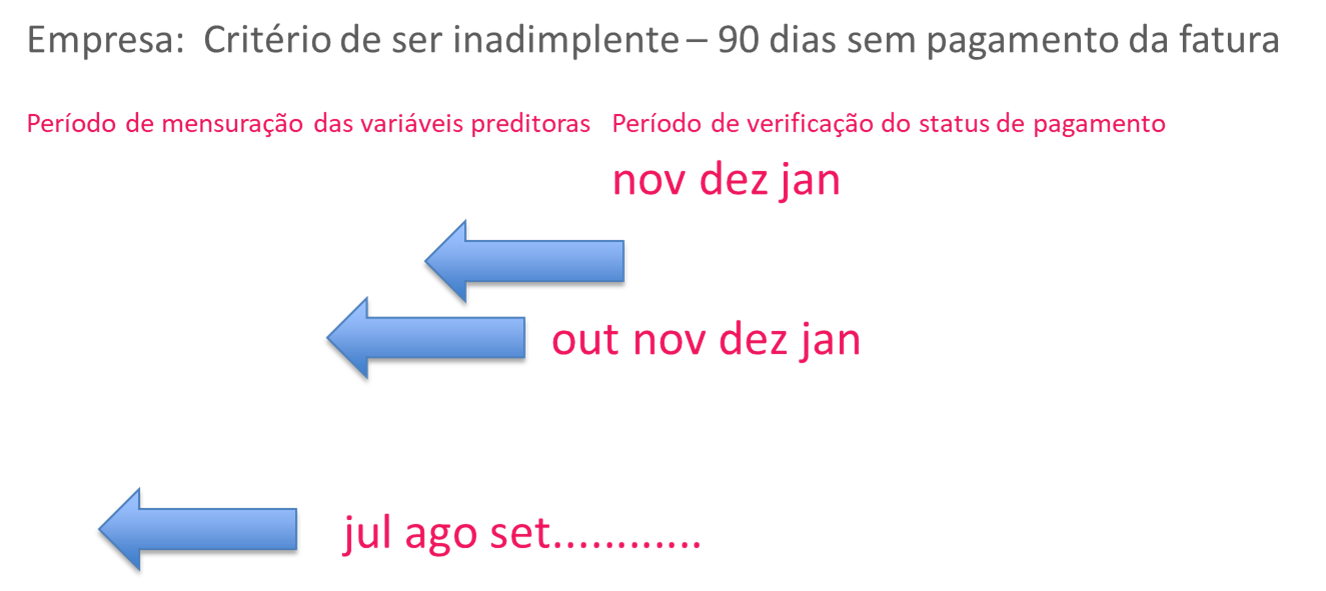

In [ ]:
# Importar as bibliotecas

import sklearn 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn import preprocessing
from sklearn import metrics 
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

In [ ]:
# Importar as bibliotecas

import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
# Importar os dados
Base_Inad = pd.read_csv("Base_Inadimplencia.csv", sep=";")

print("Total number of transactions: "+ str(Base_Inad.shape[0]))
Base_Inad.head(5)


In [ ]:
# avaliando so formatos das variáveis

Base_Inad.info()

In [ ]:
# Analise Descritiva das variáveis:

Base_Inad.describe().T

In [ ]:
# Verificando a presença de Dados nulos

pd.DataFrame(zip(Base_Inad.isnull().sum(), Base_Inad.isnull().sum()/len(Base_Inad)), columns=['Count', 'Proportion'], index=Base_Inad.columns)


 # Avaliando as variáveis: 
 
 ## Variável Target: 

In [ ]:
# Tabela de frequência da variável Resposta do modelo
Resposta =pd.pivot_table(Base_Inad, index='Resposta', values='cliente', aggfunc=np.count_nonzero)
Resposta['%'] = ((pd.pivot_table(Base_Inad, index='Resposta', values = 'cliente', aggfunc=np.count_nonzero)/Base_Inad['cliente'].count())*100).round(2)

Resposta

In [ ]:
# Como estamos construindo um modelo para prever a Inadimplência de um cliente da rede:0=Adimplente 1=Inadimplente 
# Para ter certeza de que é uma variável binária, vamos usar a função countplot () do Seaborn.
 
sb.countplot(x='Resposta',data=Base_Inad, palette='hls');

 # Variáveis Preditoras:
    
    Variável Quantitativas ou Qualitativas/categóricas

In [ ]:
# Verificando a variável Atrasos

sb.histplot(data=Base_Inad, x="Atrasos");

    O comportamento de Pagamentos do Cliente pode ser uma boa variável preditora?

In [ ]:
sb.boxplot(x='Resposta', y='Atrasos', data=Base_Inad);

   O que podemos contar sobre essa variável preditora (comportamento de pagamentos) através do gráfico boxplot?

In [ ]:
sb.boxplot(x='Resposta', y='TempoRel', data=Base_Inad);

In [ ]:
# transformando a varíavel tempo de relacionamento em anos

Base_Inad['TempoRel'] = Base_Inad['TempoRel']/365
Base_Inad.describe()

In [ ]:
sb.boxplot(x='Resposta', y='TempoRel', data=Base_Inad, palette='hls');

In [ ]:
sb.boxplot(x='Resposta', y='valorFatura', data=Base_Inad, palette='hls');

In [ ]:
# Uma opção sobre como eliminar outliers é achatamento de algum valor descrepante 
# ou pode ser a eliminação das observações
# o ponto mais importante é checar quantas observações estamos identificando como outliers.
# Cuidado para não identificar como outliers um público da base.

Base_Inad.loc[Base_Inad['valorFatura']>=50000, 'valorFatura'] = 10000         

In [ ]:
# Outra opção excluir as observaçoes 
# Excluindo outliers  

#Base_Inad = Base_Inad[Base_Inad['valorFatura'] <= 10000]


In [ ]:
Base_Inad.describe().T

In [ ]:
sb.boxplot(x='Resposta', y='valorFatura', data=Base_Inad, palette='hls');

In [ ]:
sb.boxplot(x='Resposta', y='GastosAlim', data=Base_Inad, palette='hls');

In [ ]:
sb.boxplot(x='Resposta', y='RendaMensal', data=Base_Inad, palette='hls');

## Variáveis Qualitativas ou Categóricas

In [ ]:
ordem = ['I','II','III', 'IV'] 
Base_Inad.groupby('Resposta')['RegRisc'].value_counts().unstack(0).loc[ordem].plot.bar();

In [ ]:
# comparison between RegRisc and Inadimplencia

RegRisc = pd.crosstab(Base_Inad['Resposta'],Base_Inad['RegRisc'])
RegRisc.div(RegRisc.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True, figsize=(6, 6));

Alguns algoritmos têm dificuldade em entender variáveis que possuem mais de uma categoria. Acham que é uma variável contínua (0, 1, 2, 3...) que realmente tem significado contínuo. A solução é transformar todas as categorias em uma variável diferente de valores 0 e 1, chamada de one-hot encoding (n categorias definir n variáveis). 	


Ir para o ppt apostila01 pag59  Transformação de Variáveis
Feature Engineering (etapa preparação de variáveis)

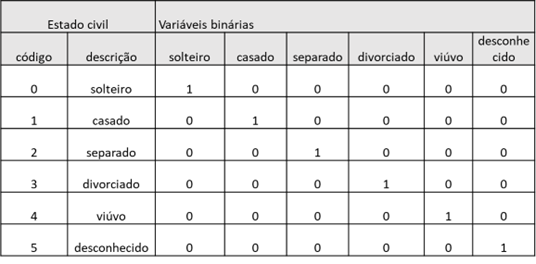

In [ ]:
# Converting categorical variables to a dummy indicators
RgRisk = pd.get_dummies(Base_Inad['RegRisc'],drop_first=True, dtype=int ,prefix='RegRisc' )

RgRisk.head()

In [ ]:
# Excluindo da base variáveis que não vamos usar para o treinamento dos modelos

Base_Inad.drop(['cliente','RegRisc'],axis=1,inplace=True)
Base_Inad.head()

In [ ]:
# Adicionando as variáveis novas transformadas

Base_Inad_dmy = pd.concat([Base_Inad,RgRisk],axis=1)
Base_Inad_dmy.head()

In [ ]:
Base_Inad_dmy.info()

In [ ]:
# 1º: Separar o conjunto em variavel resposta e variaveis de treinamento

X = Base_Inad_dmy.iloc[:,[1,2,3,4,5,6,7,8]].values
y = Base_Inad_dmy.iloc[:,0].values
X.shape, y.shape


In [ ]:
# Agora dividir em treino e teste (teste com 30%)


# Dividindo os dados em treino e teste:
X_train, X_test, y_train, y_test = train_test_split(Base_Inad_dmy.drop('Resposta',axis=1),Base_Inad_dmy['Resposta'],test_size=0.3, random_state=17)


#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

X_train.shape, X_test.shape

In [ ]:
 y_train.shape, y_test.shape

In [ ]:
 y_test.head()

In [ ]:
X_train.info()



In [ ]:
 X_train.columns

In [ ]:
X_train

### MODELO: REGRESSÃO LOGÍSTICA 

    Utilizando a biblioteca statsmodels

https://www.statsmodels.org/stable/api.html

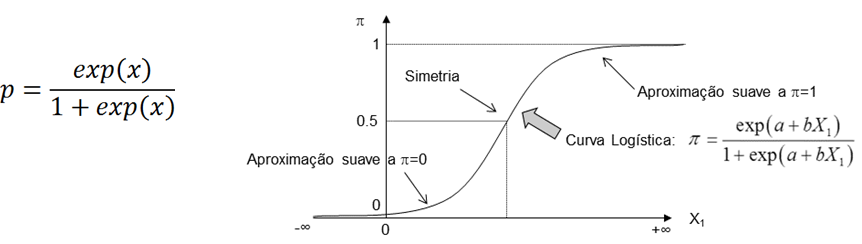

In [ ]:
# API para modelo de Regressão Logística
import statsmodels.api as sm
# Variáveis independentes (características)
# Adiciona a constante
X_ = sm.add_constant(X_train)

# Instancia e treina o modelo
logit = sm.Logit(y_train, X_.astype(float))
lg = logit.fit()

In [ ]:
X_

In [ ]:

# Imprime o resumo da Regressão Logística
print(lg.summary())

####    Agora, vamos interpretar os resultados do modelo. 
####        Os logits estimados só podem ser interpretados em termos de aumento ou diminuição de chances de inadimplencia 
####        pois que estão em escala logarítmica. 
####        Todos os coeficientes estimados foram estatisticamente significativos, isto é:
####        (p-valor abaixo de 0.05 adotando 95% de confiança).
.

####    Pessoa que mora na Região II  tem menos chance  de  ser inadinadimplente de quem mora na Região I
####    e,
####    quem mora na Região IV possui menos chance ainda
####    Quanto maior o percentual de gastos com alimentacao, menor a chance de inadimplência.
####    Estas são as intuições gerais do modelo.

####   Para obtermos coeficientes mais interpretáveis, precisamos fazer uma tranformação
####     (exp dos coeficientes) obtemos as chances relativas.

In [ ]:
# calculando a transformação 
print(np.exp(lg.params[1:]))

### 
Pessoas que moram na Região II tem 0.47 das chances de inadimplencia que as pessoas da região I.
Pessoas que moram na Região III tem 0.67 das chances de inadimplencia que as pessoas da região I.

Para cada atraso  indivíduo fica 5% das chances de outro indivíduo com as mesmas demais característica

Podemos também gerar os mesmos dados em percentuais relativos de chances para compará-los e obter uma interpretação parecida com a interpretação da regressão linear, mas em termos de chances.


In [ ]:
(np.exp(lg.params[1:]) - 1) * 100

    Agora ficou fácil!!!!!
    Pessoas da região II  tem 47% menos chances de inadimplencia do que pessoas da Região I.
    Pessoas da região III tem 67% menos chances de inadimplencia do que pessoas da Região I.
   
    Para cada atraso, as chances aumentam 5.9%.
    
    Para cada % a mais de gasto com alimentação no cartão,  as chances diminuem 3.2%.

   

###  Ir para o Simulador no excel

### Agora vamos refazer o modelo utilizando scikit-learn

O scikit-learn é uma biblioteca da linguagem Python desenvolvida especificamente para aplicação prática de machine learning.
https://scikit-learn.org/stable/
     
Esta biblioteca dispõe de ferramentas simples e eficientes para análise preditiva de dados, é reutilizável em diferentse situações, possui código aberto, sendo acessível a todos e foi construída sobre os pacotes NumPy, SciPy e matplotilib.


 Alguns passos já trabalhamos até aqui:
 avaliar as variáveis preditoras quanto a dados faltantes (missing´s),
 avaliar a presença de outliers e a tomada de alguma estratégia dado a presença deles 
 transformação de dados categóricos 

 Um próximo passo é deixar todas as variáveis numéricas de diferentes magnitudes em uma mesma escala 

 Vamos utilizar aqui a normalização Min-Max

 # Normalização Min-Max:
### transformação, onde os dados de um atributo são normalizados gerando valores  entre  0,0 a 1,0.
    

 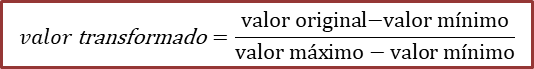

In [ ]:
# Feature Scaling 
# Only on Independent Variable 

from sklearn.preprocessing import MinMaxScaler


cols = X_train.columns

MinMax = MinMaxScaler()
X_train = MinMax.fit_transform(X_train)

#X_test = MinMax.fit_transform(X_test)
X_test = MinMax.transform(X_test)

X_train = pd.DataFrame(X_train, columns=[cols])
X_train.head()


# 1.o MODELO: REGRESSÃO LOGÍSTICA

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [ ]:
# Agora vamos refazer o modelo utilizando scikit-learn para maior facilidade de obter as métricas de ajuste.
# Agora vamos fazer com sklearn para aproveitar as métricas
#Predicting using Logistic Regression for Binary classification 

logreg = LogisticRegression(penalty=None,random_state=17)

# Verificar hiperparâmetros
# solver='newton-cg'
# solver='lbfgs'

In [ ]:
#Em seguida, você precisa treinar o seu modelo. Precisamos rodar a regressão para X_train e y_train:

# treina o modelo
logistica = logreg.fit(X_train, y_train)  #fitting the model 

In [ ]:
logistica.coef_

In [ ]:


# Os coeficientes do modelo (b1,b2,b3....)

coefficients = pd.concat([pd.DataFrame(cols),pd.DataFrame(np.transpose(logistica.coef_))], axis = 1)
coefficients


In [ ]:
# faz predicao e salva em y_pred

y_pred_log = logistica.predict(X_test)
y_pred_log


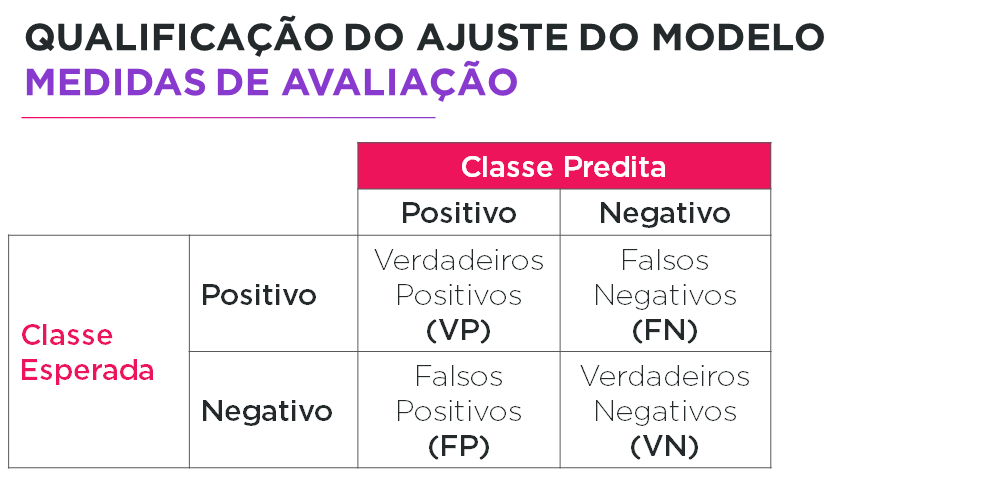

In [ ]:
# matriz de confusao
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score


confusion_matrix_log = confusion_matrix(y_test, y_pred_log)
confusion_matrix_log


In [ ]:
# acuracia Opção 1 
logistica.score(X_test, y_test)


In [ ]:
# acuracia Opção 2 
print('Accuracy: ',metrics.accuracy_score(y_test, logistica.predict(X_test)))

In [ ]:
# acuracia Opção 3 
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logistica.score(X_test, y_test)))

### Outras métricas de Performance:

### Precision score = VP/(FP+VP)) 
    Precisão: mede a precisão/exatidão do modelo.
    É a taxa entre os positivos identificados corretamente (verdadeiros positivos) e todos os positivos identificados

### Recall score = VP/(FN+VP)
    O recall, também conhecido como taxa de sensibilidade, é uma métrica que avalia a proporção de verdadeiros positivos
    em relação ao total de casos positivos reais. Ela mede a capacidade do modelo de identificar corretamente os casos positivos.


### F1 Score = 2* Precision Score * Recall Score/ (Precision Score + Recall Score)
    O F1-Score é a média harmônica entre a Precisão e o Recall e fornece um equilíbrio entre essas duas métricas.
    Ele é útil quando você deseja levar em consideração tanto os falsos positivos quanto os falsos negativos

link: https://vitalflux.com/accuracy-precision-recall-f1-score-python-example/

In [ ]:

# print(classification_report(y_test, y_pred_log))

print(classification_report(y_test, logistica.predict(X_test)))



# Resultado do classification_report:

# 2.o MODELO: ÁRVORE DE DECISÃO 

Existem vários algoritmos que podem ser utilizados nessas árvores, dentre eles o ID3, C4.5 e o CART. O foco será esta última abordagem, que é a utilizada pelo scikit-learn. Ela se baseia na separação binária (True | False) de condições utilizando os atributos — features — dos dados.

Esses modelos de aprendizado supervisionado são empregados em tarefas tanto de regressão quanto classificação. O objetivo do método é criar uma árvore que aprende com os dados por meio de regras básicas, chamadas de if-then rules. O modelo identifica qual é o melhor atributo para separar os dados utilizando o critério escolhido, que, neste caso, pode ser entropy ou gini.

A impureza de Gini mede a probabilidade de uma instância qualquer ser escolhida aleatoriamente. 
Quanto menor o valor, maior o grau de pureza daquele nó. 
Atinge seu mínimo (zero) quando todos os casos no nó caem em uma única categoria de destino

Entropia é a medida da desordem, ou da pureza. Basicamente, é a mensuração da impureza ou aleatoriedade dos dados observados. Se aproxima de 0 quando o nó está puro.

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

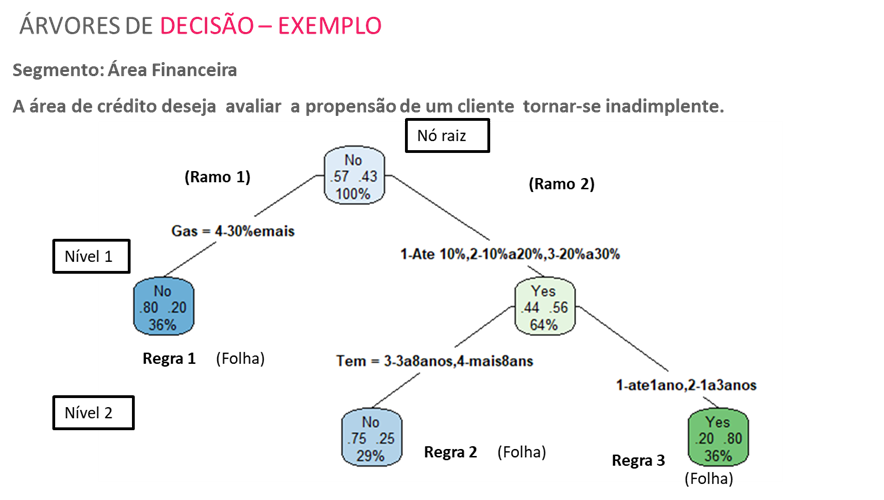

In [ ]:
# Criando modelo 

Classif_tree = DecisionTreeClassifier()
 

#### Treinando o modelo de arvore de decisão:

In [ ]:
classif = Classif_tree.fit(X_train, y_train)

# Como treinamos a árvore sem especificar nenhum parâmetro, 
# ela cresceu de forma indefinida e ficou grande demais impossibilitando a visualização da mesma.


In [ ]:
# Verificando as features mais importantes para o modelo treinado:
classif.feature_importances_

# O código acima nos retorna um array com o valor de cada variável:

In [ ]:
for feature,importancia in zip(X_train.columns,classif.feature_importances_):
    print("{}:{}".format(feature, importancia))

In [ ]:
# Testando o modelo
y_pred_all = classif.predict(X_test)

In [ ]:
y_pred_all

### Predição da Árvore de Decisão

In [ ]:
from sklearn.metrics import confusion_matrix
# Matriz de Confusão

confusion_matrix = confusion_matrix(y_test, y_pred_all)
confusion_matrix


In [ ]:
print(classification_report(y_test, y_pred_all))

# Resultado do classification_report:

# os resultados acima mostram overfitting!!!

#### Precisamos ajustar os hioperparâmetros para não gerar um modelo com overfiiting

#### Parâmetros do classificador DecisionTreeClassifier

In [ ]:
# criterion: medida de qualidade da divisão, aqui que definimos qual dessas métricas (Indice Gini, Chi-Square, Information Gain ou a redução da variância) iremos usar.
# splitter: estratégia utilizada para dividir o nó de decisão.
# max_depth: profundidade máxima da árvore.
# min_samples_split: número de amostras mínimas para considerar um nó para divisão.
# min_samples_leaf: número de amostras mínimas no nível folha.



In [ ]:
clf = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
            max_leaf_nodes=None,
            min_impurity_decrease=0.0, 
            min_samples_leaf=30, min_samples_split=10,
            min_weight_fraction_leaf=0.0,
            random_state=17, splitter='best')

clf.fit(X_train, y_train)

In [ ]:
# Verificando as features mais importantes para o modelo treinado:
clf.feature_importances_

# O código acima nos retorna um array com o valor de cada variável:

In [ ]:
for feature,importancia in zip(X_train.columns,clf.feature_importances_):
    print("{}:{}".format(feature, importancia))

In [ ]:
# criando um dicionário com as variáveis mais importantes para o modelo treinado
dic = {'score':clf.feature_importances_*100,'features':cols}
#criando um dataframe com os dados
df = pd.DataFrame(dic).sort_values('score',ascending=False)
df

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(16,12))
a = plot_tree(clf, feature_names=X_train.columns, fontsize=12,
filled=True,
class_names=['Inad(não)', 'Inad(sim)'])

In [ ]:
# Testando o modelo
y_pred = clf.predict(X_test)

In [ ]:
y_pred

# O código acima nos da a seguinte saída:

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix


In [ ]:
print(classification_report(y_test, y_pred))

# Resultado do classification_report:

In [ ]:
clf = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
            max_leaf_nodes=None,
            min_impurity_decrease=0.0, 
            min_samples_leaf=30, min_samples_split=10,
            min_weight_fraction_leaf=0.0,
            random_state=17, splitter='best')

clf.fit(X_train, y_train)

In [ ]:
# criando um dicionário com as variáveis mais importantes para o modelo treinado
dic = {'score':clf.feature_importances_*100,'features':cols}
#criando um dataframe com os dados
df = pd.DataFrame(dic).sort_values('score',ascending=False)
df

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, clf.predict(X_test))
confusion_matrix

In [ ]:
print(classification_report(y_test, clf.predict(X_test)))

# Resultado do classification_report:

A pergunta que fica é: Qual algoritmo você indicaria?????